In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import torch
from utils.Gridworld import Gridworld

In [2]:
# Test the game
game = Gridworld(size=4, mode='static')
print(game.display())
game.reward()
action_set = {
0: 'u',
1: 'd',
2: 'l',
3: 'r',
}


[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]


In [3]:
# Define the Q network 
l1 = len(game.board.render_np().flatten())
l2, l3 = 150, 100
l4 = game.board.size

gamma = 0.9
epsilon = 1.0
learning_rate = 1e-3

model = torch.nn.Sequential(
torch.nn.Linear(l1, l2),
torch.nn.ReLU(),
torch.nn.Linear(l2, l3),
torch.nn.ReLU(),
torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Train loop
epochs = 5000
losses = []
for i in range(epochs):
    game = Gridworld(size=4, mode='player')
    state_ = game.board.render_np().flatten() \
             + np.random.rand(1,64)/10.0
    
    state1 = torch.from_numpy(state_).float()
    game_on = 1
    while(game_on):
        qval = model(state1)
        qval_ = qval.data.numpy()
        if np.random.rand() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        # Get new state and reward to the action made
        state2_ = game.board.render_np().flatten() \
             + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()

        with torch.no_grad():
            newQ = model(state2)
        maxQ = torch.max(newQ)
        if reward == -1:
            Y = reward + (gamma * maxQ)

        else:
            Y = reward

        Y = torch.Tensor([Y,]).detach()
        X = qval[0:1,action_]

        loss = loss_fn(X, Y)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1:
            game_on = 0
        if epsilon > 0.1:
            epsilon -= (1/epochs)


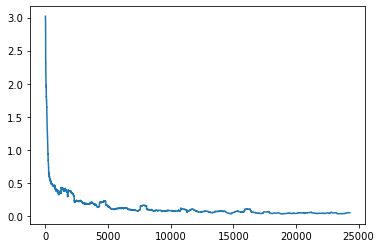

In [13]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

smooth_losses = moving_average(losses, w=500)

plt.plot(smooth_losses)
plt.show()
